## Histopathological Image Classification for Cancer Detection using Convolutional Neural Networks
This notebook is a part of Master's thesis (written in Polish). 

Abstract (English):

Medical screening is one of the main applications of image recognition systems that are supporting doctors in patient's condition evaluation. Different models are being developed simultaneously for photos coming from histopathological examinations, mammographics, blood smears, X-rays, ultrasounds, MRIs. Conclusions coming from the literature states that many models are preforming better or close to dostor's classification accuracy and are much more time efficient. Such a support could be useful considering continuously increasing volume of medical data. Development and analysis of such a solution was the goal of the thesis. Binary classification of histopathologic images of lymph nodes was performed in order to detect presence of metastatic cells. Data was published on [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection) and it included over 275 thousands of images. Convolutional neural networks with transfer learning and regularization methods were applied. The best performing architecture turned out to be DenseNet 201, which led to the result of 97.56% AUC on 51% of the test set and 97.08% on the rest of it. It places the model among first 100 of the competition's leaderboard. Taking into consideration simplicity of the program's code and relative short time spent on training (~8 hours) the model could be beneficial in supporting oncologists' decicion processes.

The model can be downloaded from GitHub.

### Data preparation 

In [1]:
# settings that keeps the libraries up to date (if any changes made by user) and image display settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# loading packages
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.metrics import error_rate

# batch size
bs = 32

In [2]:
# clear data from the GPU
torch.cuda.empty_cache()

In [3]:
# set path to main directory (dataset is in /test and /train folders)
path = '/home/jupyter/tutorials/data/'

# declare set of augmentations to apply to the training set
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=80,
                      max_zoom=1.75,
                      max_warp=0.3,
                      max_lighting=0.2, 
                      xtra_tfms=[brightness(change=(0.3, 0.9), p=0.75), 
                                 contrast(scale=(0.5, 2.), p=0.75),
                                 jitter(magnitude=0.01, p=0.75)])
# declare data using labels from csv: apply tfms, split train set into train and validation (default: 80/20),
# point on test set,  set batch size, resize to 224px, normalize using ImageNet stats
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, suffix='.tif', folder='train', test='test',
                               bs = bs, size=224).normalize(imagenet_stats)

In [4]:
# how many images
print(f'{len(os.listdir("/home/jupyter/tutorials/data//train"))} in train.')
print(f'{len(os.listdir("/home/jupyter/tutorials/data//test"))} in test.')

220025 in train.
57458 in test.


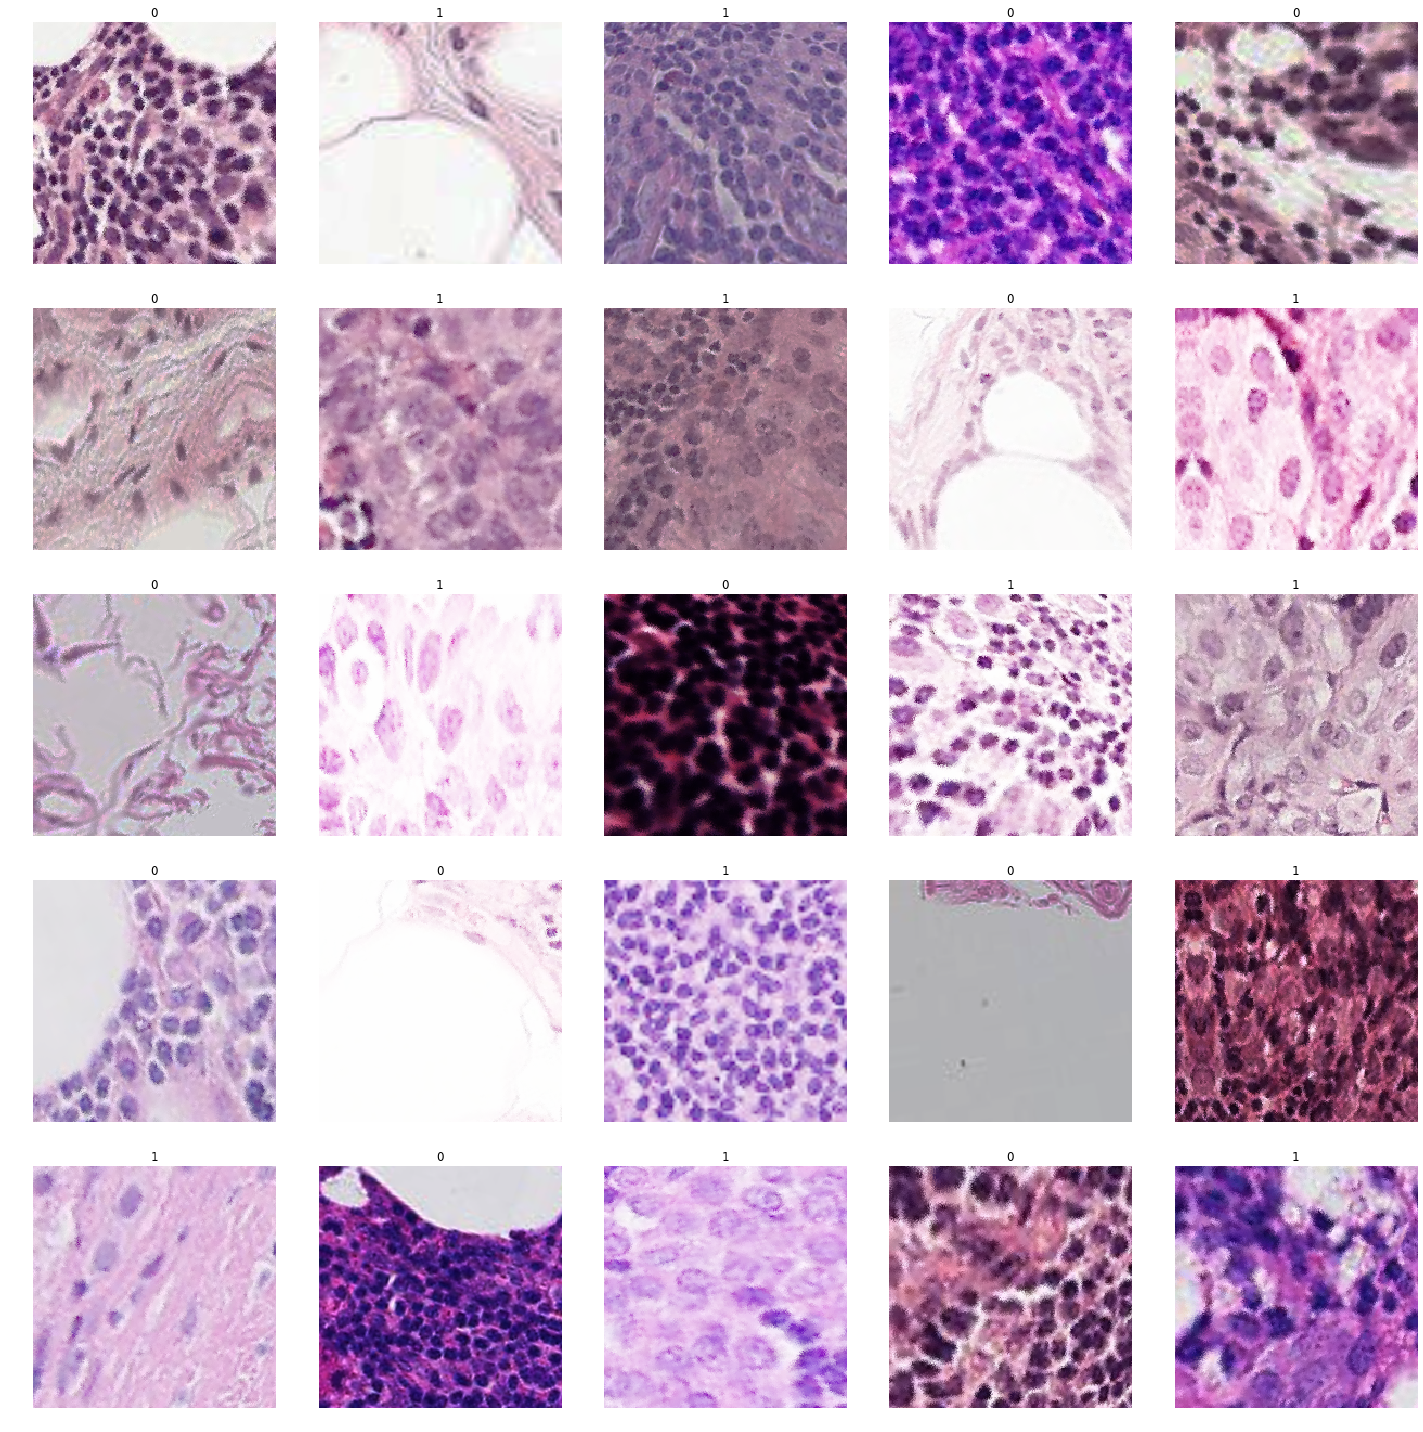

In [5]:
# show example images
data.show_batch(rows=5, fig_size=(6,6))

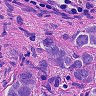

In [6]:
# select and show exaple image
def get_ex(): return open_image('/home/jupyter/tutorials/data/train/00232ca2ac86fc21b083c2b04eb73e599f662f31.tif')
get_ex()

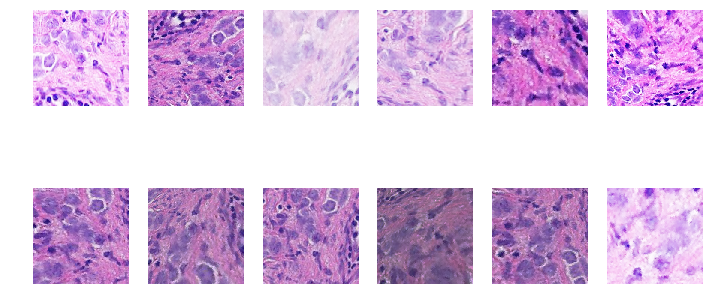

In [7]:
# show example transoramtions applied to above-mentioned photo
def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
plots_f(2, 6, 12, 6, size=224)

### Training

In [4]:
# declare learner based on Densenet 201 and use error rate as metric
learn = cnn_learner(data, models.densenet201, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


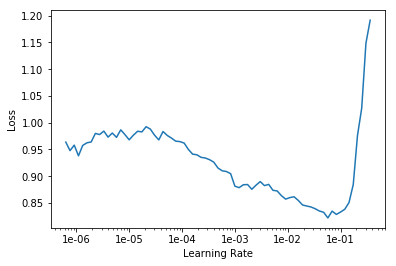

In [5]:
# plot learning rate finder in order to choose the rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# learn for 3 epochs with  1e-03 learning rate 
learn.fit_one_cycle(3, 1e-03)

In [ ]:
# save the model and load it back for further training
#learn.save('stage-1-1')
learn.load('stage-1-1')

In [ ]:
# plot loss ratio on training/validation set
learn.recorder.plot_losses()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
#learn.unfreeze()
learn.fit_one_cycle(3, 1e-07)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
#learn.save('stage-2-2')
learn.load('stage-2-2')

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, slice(1e-07,1e-06))

In [ ]:
learn.recorder.plot_losses()

In [6]:
#learn.save('stage-3-3')
learn.load('stage-3-3')

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,0,0,1
Path: /home/jupyter/tutorials/data;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,0,1,0
Path: /home/jupyter/tutorials/data;

Test: LabelList (57458 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/tutorials/data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_m

In [ ]:
#learn.lr_find()
#learn.recorder.plot()

In [ ]:
#learn.fit_one_cycle(2, 1e-06)

In [ ]:
#learn.save('stage-4-4')
#learn.load('stage-4-4')

### Results

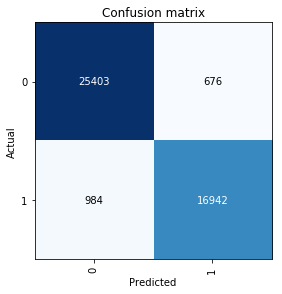

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')

In [8]:
# get predictions and plot accuracy
preds,y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds, y)

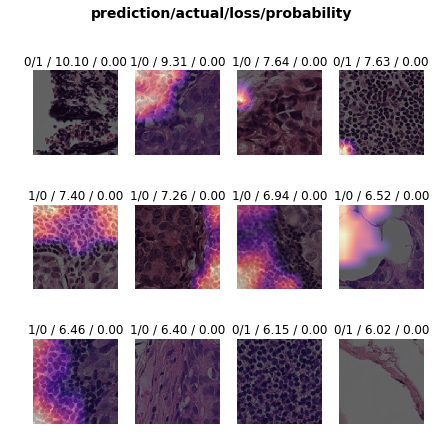

In [9]:
# plot top losses with heatmap applied
interp.plot_top_losses(12, figsize=(7,7))

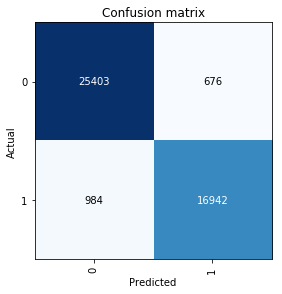

In [10]:
interp.plot_confusion_matrix(title='Confusion matrix')

In [11]:
# compute ROC/AUC on validation set
from sklearn.metrics import roc_curve, auc
# probabilities from log predicitions
probs = np.exp(preds[:,1])
# compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
# compute ROC area
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9915331958704915


In [ ]:
# generate submission for the competition
def generateSubmission(learner):
    submissions = pd.read_csv('/home/jupyter/tutorials/data/sample_submission.csv')
    id_list = list(submissions.id)
    preds,y = learner.TTA(ds_type=DatasetType.Test)
    pred_list = list(preds[:,1])
    pred_dict = dict((key, value.item()) for (key, value) in zip(learner.data.test_ds.items,pred_list))
    pred_ordered = [pred_dict[Path('/home/jupyter/tutorials/data/test/' + id + '.tif')] for id in id_list]
    submissions = pd.DataFrame({'id':id_list,'label':pred_ordered})
    submissions.to_csv("submission.csv",index = False)
generateSubmission(learn)